In [2]:
!mkdir /content/outputs

mkdir: cannot create directory ‘/content/outputs’: File exists


## Analisis:

- **content_weight/style_weight** del orden $10^{-1}$ (1-10) no presentan variaciones en la imagen generada.
- **content_weight/style_weight** del orden $10^{-3}$ o menores (1/10000) presentan variaciones en la imagen generada en la salida (mayor peso del estilo puedo notar en las pruebas blanco y negro con  los fotografos en los cielos y en el sector de los ojos en las pruebas con los pintores). Es interesante como siempre el peso mayor es del estilo del referente sobre la imagen de autor. 

- La diferencia es evidente invirtiendo la relacion (10-1), la imagen de salida contiene "menos estilo aplicado". Si bien en algunos ejemplos con rostros de personas esto no sucede. Las mejores respuestas de estilo de refente sobre las fotografias de autor, las obtuve con imágenes de paisajes y ciudades, principalmente en cielos y objetos con lineas rectas. Mientras que las últimas dos pruebas con dos obras de los pintores Caravaggio y el pintor argentino Berni, pude notar cambios en los sectores de los ojos y porsupuesto la influencia de estilo de luz en los rostros y los contornos de lineas en colores pastel.

- Cambiar valores de **total_variation_weight** no mostró un cambio significante.

**Imagenes generadas con diferentes configuraciones de peso de style y content se encuentran generadas en diferentes carpetas con su nomenclatura correspondiente** 

In [3]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import time
import argparse
from scipy.optimize import fmin_l_bfgs_b
from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [4]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.3.0


In [5]:
base_image_path = Path("/content/autor_1.jpg")
style_reference_image_path = Path("/content/autor_2.jpg")
result_prefix = Path("/content/outputs")
iterations = 100

In [6]:
total_variation_weight = 0.1
style_weight = 1
content_weight = 10

In [7]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [9]:
img_content = load_img(base_image_path, target_size=(img_nrows, img_ncols))
img_style = load_img(style_reference_image_path, target_size=(img_nrows, img_ncols))

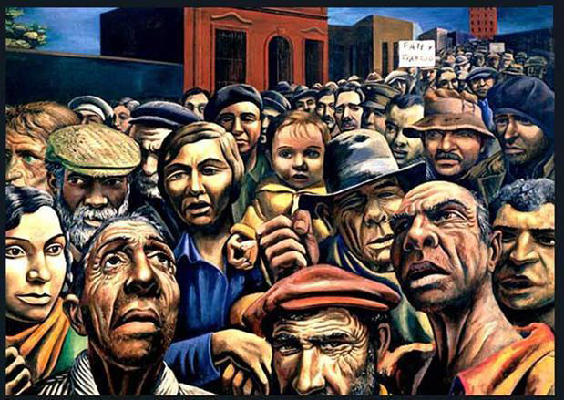

In [10]:
img_content

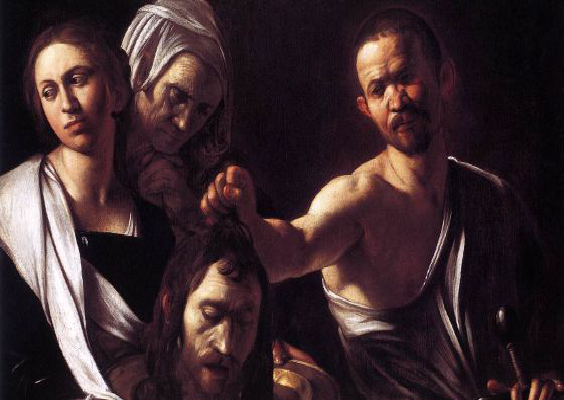

In [11]:
img_style

In [12]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [14]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [15]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [16]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

80142336/80134624 [==============================] - 0s 0us/step
Model loaded.


In [17]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [18]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [19]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [20]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [21]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
                  
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [22]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [23]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [24]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())

    #fname = result_prefix / ('output_at_iteration_%d.png' % i)
    fname = result_prefix / ('output_SW%02d_CW%02d_iteration_%02d.png' % (style_weight,content_weight, i))
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 9168017000.0
Image saved as /content/outputs/output_SW01_CW10_iteration_00.png
Iteration 0 completed in 14s
Start of iteration 1


**Ignacio Kalaydjian Martínez - reactor82@hotmail.com** 